In [1]:
import git
from pathlib import Path
import os
import cv2
import numpy as np
import random
from glob import glob
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity


ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)

DATASET = "pastis"
FINAL_DATA_NAME = 'pastis-full-fourier' # + channel
CONSTANT_SAMPLE_SIZE = int(1e5)
RAW_DATA_SUFFIX = "pastis-RGB-jitter"
SAVE_DF = False

data_dir = os.path.join(ROOT_DIR, 'raw-data','pastis')
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
file_names = os.listdir(data_dir)
data_dir
BATCH_NUM = None

In [2]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from transform import *
from testing import *
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "dataset-preparation"))


In [3]:
file_list = [os.path.join(data_dir, f"full-{RAW_DATA_SUFFIX}", filename) for filename in os.listdir(data_dir)]
file_names = os.listdir(os.path.join(data_dir, f"full-{RAW_DATA_SUFFIX}"))
file_names[:5]

['test519.npz', 'test525.npz', 'test243.npz', 'test257.npz', 'test531.npz']

In [4]:
num_images= len(file_names)
print(f"Number of images: {num_images}")

Number of images: 1590


In [5]:
FINAL_DATA_NAME = 'pastis-full-wavelet'
if BATCH_NUM is None:
    batch_dir = os.path.join(ROOT_DIR, "raw-data", "pastis", f"full-{RAW_DATA_SUFFIX}")
else:
    batch_dir = os.path.join(ROOT_DIR, "raw-data", "pastis", f"batch{BATCH_NUM}-{RAW_DATA_SUFFIX}")

In [6]:
def convert_to_wavelet_basis_unflat(folder_dir, color, basis="db1", image_func = None, debug = False, image_opener = None):
    file_list = [os.path.join(folder_dir, filename) for filename in os.listdir(folder_dir) if filename != ".DS_Store"]
    #Setup df Dict
    if image_opener != None:
        image = rgb2gray(image_opener(file_list[0]))
    else:
        image = Image.open(file_list[0]).convert('L')
    first_image = pywt.wavedec2(image, basis)
    layer_len = len(first_image)
    print(str(layer_len) + " layers being used")
    sleep(0.3)
    color_dict = {"red":0, "green":1, "blue":2, "gray":3, "infrared": 4}
    c = color_dict[color]

    #Fill DF DICT
    layer_arr = [0] * (len(file_list) * (layer_len - 1) * 3 + len(file_list))
    orientation = [0] * (len(file_list) * (layer_len - 1) * 3 + len(file_list))
    data_arr = [0] * (len(file_list) * (layer_len - 1) * 3 + + len(file_list))
    cnt = 0
    if debug:
        loop = tqdm(range(len(file_list)))
    else:
        loop = range(len(file_list))
    for k in loop:
        if c >= 3:
            if image_opener != None:
                image = rgb2gray(image_opener(file_list[k]))
            else:
                image = Image.open(file_list[k]).convert('L')
    
        else:
            if image_opener != None:
                image = image_opener(file_list[k])[:,:,c]
            else:
                image = np.array(Image.open(file_list[k]))[:,:,c]

        if image_func != None:
            image = image_func(image)

    
        transformed = pywt.wavedec2(image, 'db1')
        direction_names = ['H', 'V', 'D']

        arr = np.array(transformed[0][0])
        layer_arr[cnt] = 1
        orientation[cnt] =  "L1"
        data_arr[cnt] = arr.flatten()
        cnt += 1

        for i in range(1, layer_len): 
            for j in range(len(transformed[i])):
                
                arr = np.array(transformed[i][j])
                layer_arr[cnt] = i+1
                orientation[cnt] =  direction_names[j]
                data_arr[cnt] = arr.flatten()
                cnt += 1

    df = pd.DataFrame()

    df["layer"] = layer_arr
    df["orientation"] = orientation
    df["data"] = data_arr
    new_df = pd.DataFrame(columns=["channel","layer", "frequency", "orientation", "data"])
    for lo, sf in df.groupby(["layer", "orientation"])[["data"]]:#.agg(lambda sf: np.concatenate(sf["Data"].tonumpy()))
        new_df.loc[len(new_df.index)] = [color, lo[0], pywt.scale2frequency(basis,layer_len - (lo[0]-1)),lo[1],  sf['data'].to_numpy()]

    return new_df

In [7]:
TRANSFORM = "wavelet"
channel = "gray"

channel_wv = convert_to_wavelet_basis_unflat(batch_dir, channel, debug = True, image_opener = npz_opener)
#channel_wv['data'] = channel_wv['data'].apply(lambda x : x.astype(np.float32))


8 layers being used


  0%|          | 0/1590 [00:00<?, ?it/s]

In [ ]:
n_bootstrap = int(1e6) 

In [9]:
def bootstrap_wavelet_data(x):
    arr = []
    for i in tqdm(range(len(idx))):
        arr.append(np.random.choice(x[idx[i]], size=1))
    return np.concatenate(arr).flatten()

In [10]:
idx = np.random.randint(0, num_images, (n_bootstrap))
channel_wv["bootstrapped_train"] = channel_wv["data"].apply(bootstrap_wavelet_data)
idx = np.random.randint(0, num_images, (n_bootstrap))
channel_wv["bootstrapped_test"] = channel_wv["data"].apply(bootstrap_wavelet_data)
idx = np.random.randint(0, num_images, (n_bootstrap))
channel_wv["bootstrapped_train2"] = channel_wv["data"].apply(bootstrap_wavelet_data)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [11]:
df = channel_wv[channel_wv["orientation"] == "D"].copy()
master_df = pd.read_csv(f"{ROOT_DIR}{os.sep}results/case-studies/pastis/full/wavelet/diagonal/gray/CSVs/master_df.csv")
master_df = master_df[["layer", "best_r", "best_eta", "best_scale"]]
df["generated"] = [sample_prior(r = r, eta = eta, scale = scale, size = n_bootstrap) for r, eta, scale in zip(master_df["best_r"].values, master_df["best_eta"].values, master_df["best_scale"].values)]
full_arr_train = df["bootstrapped_train"].to_numpy()
full_arr_train2 = df["bootstrapped_train2"].to_numpy()
full_arr_test = df["bootstrapped_test"].to_numpy()
full_arr_generated = df["generated"].to_numpy()


In [12]:

def knn_density_estimator(samples, k, eps = 1e-32):
    samples = np.asarray(samples)
    n = len(samples)
    nbrs = NearestNeighbors(n_neighbors=k).fit(samples)

    def density_fn(x):
        distances, _ = nbrs.kneighbors([x])
        rk = distances[0][-1]
        volume = np.pi * rk**2
        return k / (n * volume + eps)
    

    return density_fn


In [13]:
def kde_density_estimator(samples, kernel='gaussian'):
    kde = KernelDensity(kernel=kernel)
    kde.fit(samples)

    def density_fn(x):
        x = np.atleast_2d(x)
        log_density = kde.score_samples(x)  # returns log p(x)
        return np.exp(log_density[0])       # convert log-density to density

    return density_fn

In [16]:
import numpy as np
from scipy.integrate import nquad

def knn_log_density_estimator_2d(samples, k):
    """
    Returns a function log_p(x, y) that gives log-density at any point (x, y)
    based on 2D KNN estimation.
    
    Parameters:
    - samples: ndarray of shape (n_samples, 2)
    - k: number of neighbors
    """
    samples = np.asarray(samples)
    n = len(samples)
    nbrs = NearestNeighbors(n_neighbors=k)
    nbrs.fit(samples)
    
    def log_density(x):
       
        distances, _ = nbrs.kneighbors([x])
        rk = distances[0][-1]
        volume = np.pi * rk**2  # Area of circle in 2D
        density = k / (n * volume)
        return np.log(density + 1e-300)  # avoid log(0)
    
    return log_density

def kl_divergence_2d(p, q, x_bounds, y_bounds, eps=1e-300):
    """
    Compute the KL divergence D_KL(p || q) for two 2D densities via quadrature.

    Parameters:
    - p: function (x, y) -> float, the first density function
    - q: function (x, y) -> float, the second density function
    - x_bounds: tuple (x_min, x_max), bounds for x
    - y_bounds: tuple (y_min, y_max), bounds for y
    - eps: small constant to avoid log(0) or division by 0

    Returns:
    - float: KL divergence estimate
    """
    def integrand(y, x):  # Note: dblquad expects integrand(y, x)
        px = max(p([x, y]), eps)
        qx = max(q([x, y]), eps)
        return px * np.log(px / qx)
    
    def integrand(y, x):
        lp = p([x, y])
        lq = q([x, y])
        if not np.isfinite(lp) or not np.isfinite(lq):
            return 0.0
        return np.exp(lp) * (lp - lq)

    x_min, x_max = x_bounds
    y_min, y_max = y_bounds

    result, err = nquad(
                        integrand,
                        [[x_min, x_max], [y_min, y_max]],
                        opts=[{"limit": 200}, {"limit": 200}]
)
    return result


In [17]:
x1 = 2
x2 = 3
samples_train = np.array([full_arr_train[x1-2], full_arr_train[x2-2]]).T
samples_train2 = np.array([full_arr_train2[x1-2], full_arr_train2[x2-2]]).T

samples_test = np.array([full_arr_test[x1-2], full_arr_test[x2-2]]).T
samples_generated = np.array([full_arr_generated[x1-2], full_arr_generated[x2-2]]).T
prior_x1 = compute_prior_pdf(r = master_df["best_r"].values[x1-2], eta = master_df["best_eta"].values[x1-2], scale = master_df["best_scale"].values[x1-2], n_samples = 3000)[1]
prior_x2 = compute_prior_pdf(r = master_df["best_r"].values[x2-2], eta = master_df["best_eta"].values[x2-2], scale = master_df["best_scale"].values[x2-2], n_samples = 3000)[1]
#prior_joint = kde_density_estimator(samples)
prior_joint = knn_density_estimator(samples_train, k =100)
prior_joint2 = knn_density_estimator(samples_train2, k =100)
prior_generated = knn_density_estimator(samples_generated, k = 100)

prior_joint_log =knn_log_density_estimator_2d(samples_train, k=100)
prior_joint2_log = knn_log_density_estimator_2d(samples_train2, k=100)
prior_generated_log = knn_log_density_estimator_2d(samples_generated, k=100)

In [18]:
mi = 0
mi2 = 0
for sample in tqdm(samples_test):
    x1_eval = max(prior_x1(sample[0]), 1e-32)
    x2_eval = max(prior_x2(sample[1]), 1e-32)
    mi2 += np.log(prior_joint(sample)) - (np.log(x1_eval) + np.log(x2_eval))
    
    mi += np.log(prior_joint(sample)) - np.log(prior_generated(sample)) 
    
mi = mi / len(samples_test)
mi2 = mi2 / len(samples_test)
mi, mi2

  0%|          | 0/1000000 [00:00<?, ?it/s]

(87.33004965280571, 87.33989525945498)

In [34]:
mi_results = []
mi2_results = []

for x1 in range(2, max(channel_wv["layer"])+ 1):
    for x2 in range(x1+1, max(channel_wv["layer"])+1):
        samples_train = np.array([full_arr_train[x1-2], full_arr_train[x2-2]]).T
        samples_train2 = np.array([full_arr_train2[x1-2], full_arr_train2[x2-2]]).T
        samples_test = np.array([full_arr_test[x1-2], full_arr_test[x2-2]]).T
        samples_generated = np.array([full_arr_generated[x1-2], full_arr_generated[x2-2]]).T
        prior_x1 = compute_prior_pdf(r = master_df["best_r"].values[x1-2], eta = master_df["best_eta"].values[x1-2], scale = master_df["best_scale"].values[x1-2], n_samples = 3000)[1]
        prior_x2 = compute_prior_pdf(r = master_df["best_r"].values[x2-2], eta = master_df["best_eta"].values[x2-2], scale = master_df["best_scale"].values[x2-2], n_samples = 3000)[1]
        prior_joint = knn_density_estimator(samples_train, k=100)
        prior_joint2 = knn_density_estimator(samples_train2, k=100)
        prior_generated = knn_density_estimator(samples_generated, k=100)

        mi_list = []
        mi2_list = []
        for sample in tqdm(samples_test):
            x1_eval = max(prior_x1(sample[0]), 1e-32)
            x2_eval = max(prior_x2(sample[1]), 1e-32)
            mi2_list.append(np.log(prior_joint2(sample)) - (np.log(x1_eval) + np.log(x2_eval)))

            mi_list.append(np.log(prior_joint(sample)) - np.log(prior_generated(sample)))

        mi = np.mean(mi_list)
        mi2 = np.mean(mi2_list)
        mi_std = np.std(mi_list)
        mi2_std = np.std(mi2_list)
        # 95% confidence intervals (normal approx)
        mi_ci = (mi - 1.96 * mi_std / np.sqrt(len(mi_list)), mi + 1.96 * mi_std / np.sqrt(len(mi_list)))
        mi2_ci = (mi2 - 1.96 * mi2_std / np.sqrt(len(mi2_list)), mi2 + 1.96 * mi2_std / np.sqrt(len(mi2_list)))
        print(f"Mutual Information between layers {x1} and {x2}: {mi} (std={mi_std}, 95% CI={mi_ci})")
        print(f"Mutual Information (2) between layers {x1} and {x2}: {mi2} (std={mi2_std}, 95% CI={mi2_ci})")
        mi_results.append({'Layer 1': x1, 'Layer 2': x2, 'Mutual Information': mi, 'Std': mi_std, '95% CI': mi_ci})
        mi2_results.append({'Layer 1': x1, 'Layer 2': x2, 'Mutual Information (2)': mi2, 'Std': mi2_std, '95% CI': mi2_ci})

mi_df = pd.DataFrame(mi_results)
mi2_df = pd.DataFrame(mi2_results)


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 2 and 3: 0.19553424808851305 (std=0.5007509206943985, 95% CI=(0.1924305617268646, 0.1986379344501615))
Mutual Information (2) between layers 2 and 3: 0.224197080968605 (std=0.5302296156357187, 95% CI=(0.22091068376276737, 0.22748347817444262))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 2 and 4: 0.08363579660821677 (std=0.34759603800253774, 95% CI=(0.08148137404416937, 0.08579021917226416))
Mutual Information (2) between layers 2 and 4: 0.10478493725327358 (std=0.36196418571336286, 95% CI=(0.10254145998707927, 0.10702841451946789))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 2 and 5: 0.06584053408727869 (std=0.3107578419766342, 95% CI=(0.06391443702772519, 0.06776663114683219))
Mutual Information (2) between layers 2 and 5: 0.10239471749996319 (std=0.33801827146971447, 95% CI=(0.10029965854791227, 0.10448977645201411))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 2 and 6: 0.10336167258219893 (std=0.36215862225063394, 95% CI=(0.10111699018586108, 0.10560635497853678))
Mutual Information (2) between layers 2 and 6: 0.15528753985668248 (std=0.400924330416616, 95% CI=(0.1528025851118334, 0.15777249460153156))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 2 and 7: 0.17589802719987496 (std=0.4786190214627882, 95% CI=(0.17293151577084026, 0.17886453862890966))
Mutual Information (2) between layers 2 and 7: 0.25492113421776097 (std=0.5340414980065694, 95% CI=(0.25161111072021286, 0.2582311577153091))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 2 and 8: 0.3284318830568955 (std=0.6627932338448218, 95% CI=(0.324323848032967, 0.33253991808082406))
Mutual Information (2) between layers 2 and 8: 0.3907569551375613 (std=0.7738104506032326, 95% CI=(0.38596082827531236, 0.39555308199981026))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 3 and 4: 0.021212034215097236 (std=0.22930752552348938, 95% CI=(0.01979077144716525, 0.02263329698302922))
Mutual Information (2) between layers 3 and 4: 0.04277386246537105 (std=0.25050412241189873, 95% CI=(0.041221221828807914, 0.044326503101934187))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 3 and 5: 0.013951294995607039 (std=0.20606264524581697, 95% CI=(0.012674105488281184, 0.015228484502932894))
Mutual Information (2) between layers 3 and 5: 0.039764222272907365 (std=0.22862854368796257, 95% CI=(0.03834716787799207, 0.04118127666782266))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 3 and 6: 0.018256231087420163 (std=0.2147669273252444, 95% CI=(0.016925091880829857, 0.01958737029401047))
Mutual Information (2) between layers 3 and 6: 0.05488788559535504 (std=0.2620260299232968, 95% CI=(0.0532638314361693, 0.05651193975454078))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 3 and 7: 0.03244328982819564 (std=0.2634522619798817, 95% CI=(0.030810395791139214, 0.03407618386525206))
Mutual Information (2) between layers 3 and 7: 0.09050102133598953 (std=0.349223937202973, 95% CI=(0.08833650894816404, 0.09266553372381502))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 3 and 8: 0.06029072849347713 (std=0.3310076830498289, 95% CI=(0.058239121618630096, 0.06234233536832416))
Mutual Information (2) between layers 3 and 8: 0.13295654537146812 (std=0.5204610055502243, 95% CI=(0.12973069463822123, 0.136182396104715))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 4 and 5: 0.0051824008266640464 (std=0.18726345773815226, 95% CI=(0.004021729890680408, 0.006343071762647685))
Mutual Information (2) between layers 4 and 5: 0.024750673011846906 (std=0.19904899018093794, 95% CI=(0.023516954588987525, 0.025984391434706287))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 4 and 6: 0.002516854361826513 (std=0.17383960928941222, 95% CI=(0.00143938530052623, 0.0035943234231267957))
Mutual Information (2) between layers 4 and 6: 0.030371626654566424 (std=0.20184839552946843, 95% CI=(0.029120557337596033, 0.031622695971536816))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 4 and 7: 0.0017146407670455743 (std=0.18004888356668505, 95% CI=(0.0005986862250528505, 0.0028305953090382984))
Mutual Information (2) between layers 4 and 7: 0.0465584347348631 (std=0.25381833772834494, 95% CI=(0.04498525237894984, 0.04813161709077635))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 4 and 8: 0.008345045350074187 (std=0.19320626797303078, 95% CI=(0.007147540494643571, 0.009542550205504804))
Mutual Information (2) between layers 4 and 8: 0.07389074326544304 (std=0.3724066981757233, 95% CI=(0.07158254263645225, 0.07619894389443382))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 5 and 6: 0.0008375539218245126 (std=0.1655893117653668, 95% CI=(-0.0001887792656377089, 0.001863887109286734))
Mutual Information (2) between layers 5 and 6: 0.02164317838868397 (std=0.17781537426613958, 95% CI=(0.020541067280758437, 0.022745289496609502))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 5 and 7: -0.0030043411396054724 (std=0.1589459849511956, 95% CI=(-0.003989498560879338, -0.002019183718331607))
Mutual Information (2) between layers 5 and 7: 0.030728801867063876 (std=0.19834665746096528, 95% CI=(0.02949943654750243, 0.03195816718662532))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 5 and 8: -0.0034969548882569806 (std=0.1537620679714486, 95% CI=(-0.004449982059210692, -0.0025439277173032694))
Mutual Information (2) between layers 5 and 8: 0.0475678869863406 (std=0.2786161804127074, 95% CI=(0.04584100600910273, 0.04929476796357848))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 6 and 7: -0.00023675245215249078 (std=0.1634877988763959, 95% CI=(-0.001250060327782469, 0.0007765554234774874))
Mutual Information (2) between layers 6 and 7: 0.02210843740106227 (std=0.17942455957142908, 95% CI=(0.020996352459282438, 0.0232205223428421))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 6 and 8: -0.002678810414376338 (std=0.15800740100228555, 95% CI=(-0.003658150432064695, -0.0016994703966879813))
Mutual Information (2) between layers 6 and 8: 0.03144886971165876 (std=0.23088633870196448, 95% CI=(0.030017821358264786, 0.03287991806505273))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information between layers 7 and 8: -0.0008215115714925553 (std=0.16604507639879065, 95% CI=(-0.0018506696174191762, 0.00020764647443406552))
Mutual Information (2) between layers 7 and 8: 0.023622501170002207 (std=0.19587977224812517, 95% CI=(0.02240842576339834, 0.024836576576606074))


In [35]:
mi_df

,Layer 1,Layer 2,Mutual Information,Std,95% CI
0,2,3,0.195534,0.500751,"(0.1924305617268646, 0.1986379344501615)"
1,2,4,0.083636,0.347596,"(0.08148137404416937, 0.08579021917226416)"
2,2,5,0.065841,0.310758,"(0.06391443702772519, 0.06776663114683219)"
3,2,6,0.103362,0.362159,"(0.10111699018586108, 0.10560635497853678)"
4,2,7,0.175898,0.478619,"(0.17293151577084026, 0.17886453862890966)"
5,2,8,0.328432,0.662793,"(0.324323848032967, 0.33253991808082406)"
6,3,4,0.021212,0.229308,"(0.01979077144716525, 0.02263329698302922)"
7,3,5,0.013951,0.206063,"(0.012674105488281184, 0.015228484502932894)"
8,3,6,0.018256,0.214767,"(0.016925091880829857, 0.01958737029401047)"
9,3,7,0.032443,0.263452,"(0.030810395791139214, 0.03407618386525206)"


In [36]:
mi2_df

,Layer 1,Layer 2,Mutual Information (2),Std,95% CI
0,2,3,0.224197,0.530230,"(0.22091068376276737, 0.22748347817444262)"
1,2,4,0.104785,0.361964,"(0.10254145998707927, 0.10702841451946789)"
2,2,5,0.102395,0.338018,"(0.10029965854791227, 0.10448977645201411)"
3,2,6,0.155288,0.400924,"(0.1528025851118334, 0.15777249460153156)"
4,2,7,0.254921,0.534041,"(0.25161111072021286, 0.2582311577153091)"
5,2,8,0.390757,0.773810,"(0.38596082827531236, 0.39555308199981026)"
6,3,4,0.042774,0.250504,"(0.041221221828807914, 0.044326503101934187)"
7,3,5,0.039764,0.228629,"(0.03834716787799207, 0.04118127666782266)"
8,3,6,0.054888,0.262026,"(0.0532638314361693, 0.05651193975454078)"
9,3,7,0.090501,0.349224,"(0.08833650894816404, 0.09266553372381502)"


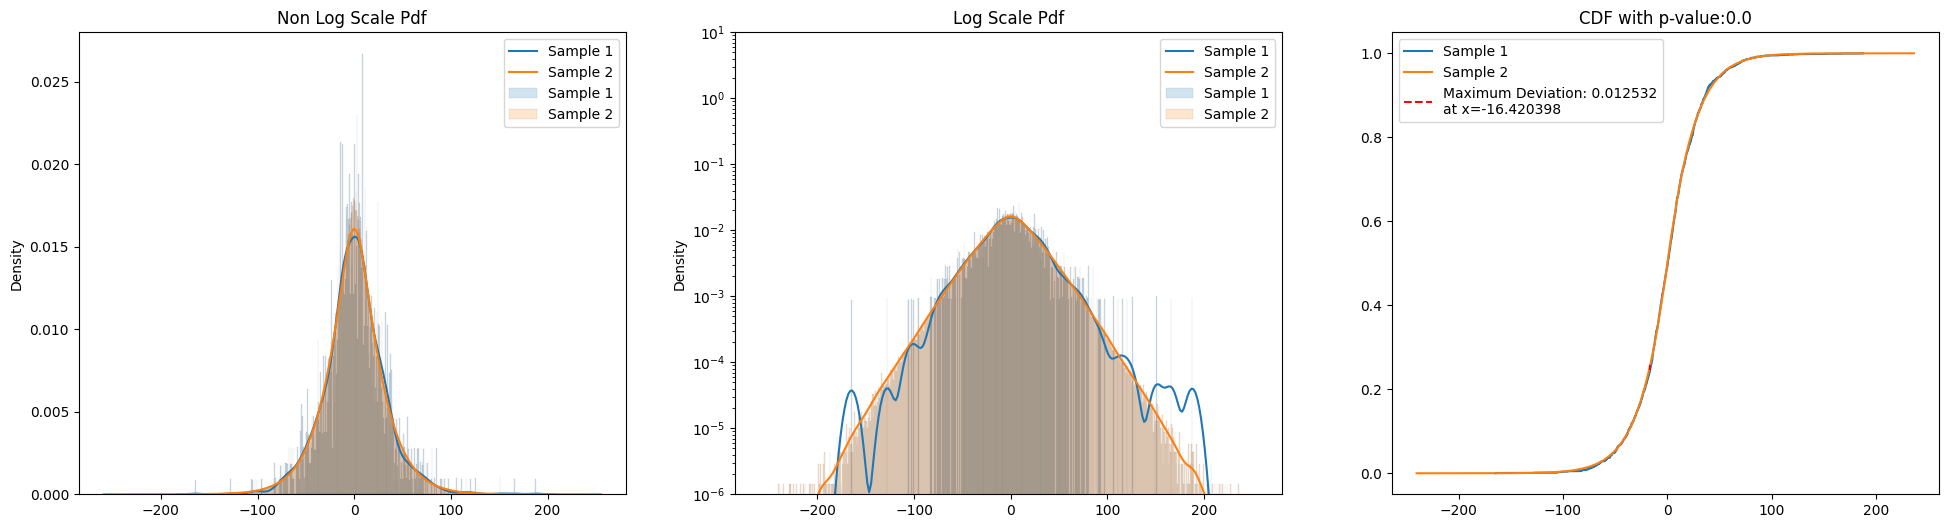

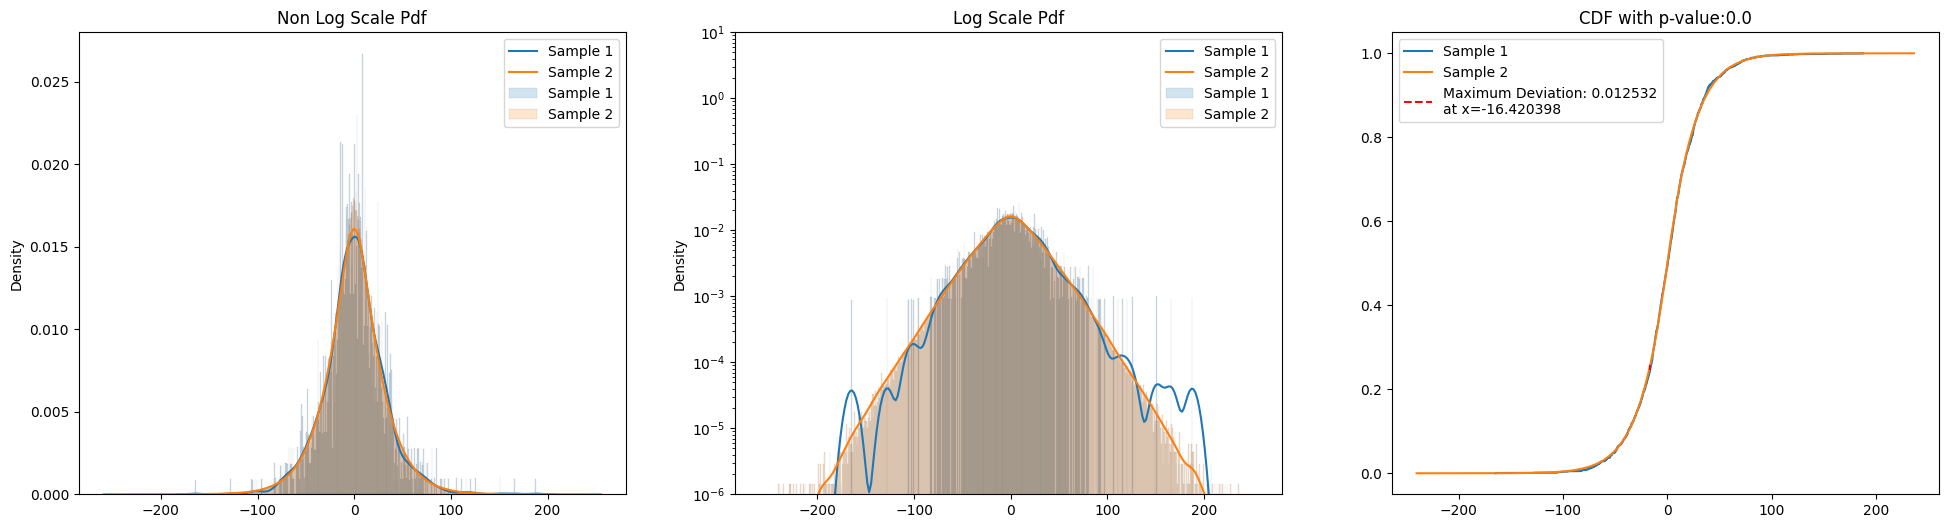

In [14]:
twoSampleComparisonPlots(full_arr_train[0], full_arr_generated[0])

In [38]:

def knn_density_estimator_1d(samples, k, eps=1e-32):
    samples = np.asarray(samples).reshape(-1, 1)
    n = len(samples)
    nbrs = NearestNeighbors(n_neighbors=k).fit(samples)

    def density_fn(x):
        x = np.asarray(x).reshape(1, -1)
        distances, _ = nbrs.kneighbors(x)
        rk = distances[0][-1]  # Distance to the k-th nearest neighbor
        volume = 2 * rk  # In 1D, volume is just length of the interval
        return k / (n * volume + eps)

    return density_fn


In [39]:
mi_results_one = []
mi2_results_one = []

for x1 in range(2, max(channel_wv["layer"])+ 1):
    samples_train = np.array([full_arr_train[x1-2]]).T
    samples_generated = np.array([full_arr_generated[x1-2]]).T
    prior_x1 = compute_prior_pdf(r = master_df["best_r"].values[x1-2], eta = master_df["best_eta"].values[x1-2], scale = master_df["best_scale"].values[x1-2], n_samples = 3000)[1]
    prior_joint = knn_density_estimator_1d(samples_train, k=100)
    prior_generated = knn_density_estimator_1d(samples_generated, k=100)

    mi_list_one = []
    mi2_list_one = []
    for sample in tqdm(samples_train):
        x1_eval = max(prior_x1(sample[0]), 1e-32)
        mi2_list_one.append(np.log(prior_joint(sample)) - (np.log(x1_eval)))


        mi_list_one.append(np.log(prior_joint(sample)) - np.log(prior_generated(sample)))


    mi = np.mean(mi_list_one)
    mi2 = np.mean(mi2_list_one)
    mi_std = np.std(mi_list_one)
    mi2_std = np.std(mi2_list_one)
    # 95% confidence intervals (normal approx)
    mi_ci = (mi - 1.96 * mi_std / np.sqrt(len(mi_list_one)), mi + 1.96 * mi_std / np.sqrt(len(mi_list_one)))
    mi2_ci = (mi2 - 1.96 * mi2_std / np.sqrt(len(mi2_list_one)), mi2 + 1.96 * mi2_std / np.sqrt(len(mi2_list_one)))
    print(f"Mutual Information (2) between layers {x1}: {mi2} (std={mi2_std}, 95% CI={mi2_ci})")
    print(f"Mutual Information between layers {x1}: {mi} (std={mi_std}, 95% CI={mi_ci})")
    mi_results_one.append({'Layer 1': x1, 'Mutual Information': mi, 'Std': mi_std, '95% CI': mi_ci})
    mi2_results_one.append({'Layer 1': x1, 'Mutual Information (2)': mi2, 'Std': mi2_std, '95% CI': mi2_ci})

mi_df_one = pd.DataFrame(mi_results_one)
mi2_df_one = pd.DataFrame(mi2_results_one)
mi_df_one, mi2_df_one

  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information (2) between layers 2: 1.0202787638353892 (std=1.274117868720082, 95% CI=(1.0123816994689465, 1.0281758282018318))
Mutual Information between layers 2: 1.007032366578713 (std=1.2722652710666225, 95% CI=(0.9991467847314891, 1.0149179484259372))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information (2) between layers 3: 0.1833513494872663 (std=0.4492623293205854, 95% CI=(0.18056679272123755, 0.18613590625329507))
Mutual Information between layers 3: 0.17735107271423342 (std=0.4593502159949858, 95% CI=(0.17450399057881388, 0.18019815484965296))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information (2) between layers 4: 0.058133578849523665 (std=0.23329551874852283, 95% CI=(0.056687598243498206, 0.05957955945554912))
Mutual Information between layers 4: 0.05273283443448587 (std=0.2564046100697554, 95% CI=(0.05114362219652584, 0.0543220466724459))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information (2) between layers 5: 0.027414759765140694 (std=0.14500370227335366, 95% CI=(0.026516017507192857, 0.028313502023088532))
Mutual Information between layers 5: 0.02126746264006015 (std=0.17099193205830898, 95% CI=(0.020207643665098793, 0.02232728161502151))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information (2) between layers 6: 0.018236538156063718 (std=0.11608231266663407, 95% CI=(0.017517052528054418, 0.018956023784073017))
Mutual Information between layers 6: 0.012768253165983416 (std=0.15464742230931866, 95% CI=(0.011809738511991505, 0.013726767819975328))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information (2) between layers 7: 0.017610695926278758 (std=0.11246117892633496, 95% CI=(0.01691365431771906, 0.018307737534838456))
Mutual Information between layers 7: 0.012880471683153174 (std=0.15273168855954158, 95% CI=(0.011933830869959174, 0.013827112496347174))


  0%|          | 0/100000 [00:00<?, ?it/s]

Mutual Information (2) between layers 8: 0.016624979988634797 (std=0.10761681778153526, 95% CI=(0.015957964041526034, 0.01729199593574356))
Mutual Information between layers 8: 0.01115783809392031 (std=0.14706228769238058, 95% CI=(0.010246336591355485, 0.012069339596485136))


(   Layer 1  Mutual Information       Std  \
 0        2            1.007032  1.272265   
 1        3            0.177351  0.459350   
 2        4            0.052733  0.256405   
 3        5            0.021267  0.170992   
 4        6            0.012768  0.154647   
 5        7            0.012880  0.152732   
 6        8            0.011158  0.147062   
 
                                          95% CI  
 0      (0.9991467847314891, 1.0149179484259372)  
 1    (0.17450399057881388, 0.18019815484965296)  
 2     (0.05114362219652584, 0.0543220466724459)  
 3   (0.020207643665098793, 0.02232728161502151)  
 4  (0.011809738511991505, 0.013726767819975328)  
 5  (0.011933830869959174, 0.013827112496347174)  
 6  (0.010246336591355485, 0.012069339596485136)  ,
    Layer 1  Mutual Information (2)       Std  \
 0        2                1.020279  1.274118   
 1        3                0.183351  0.449262   
 2        4                0.058134  0.233296   
 3        5                0.0274

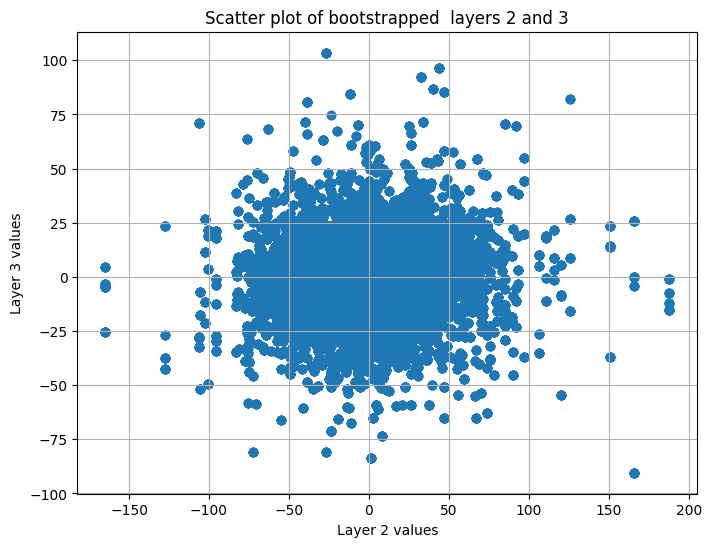

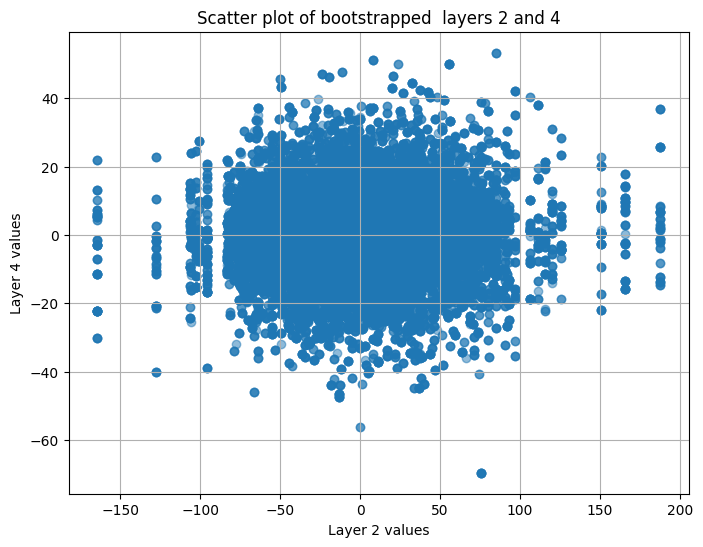

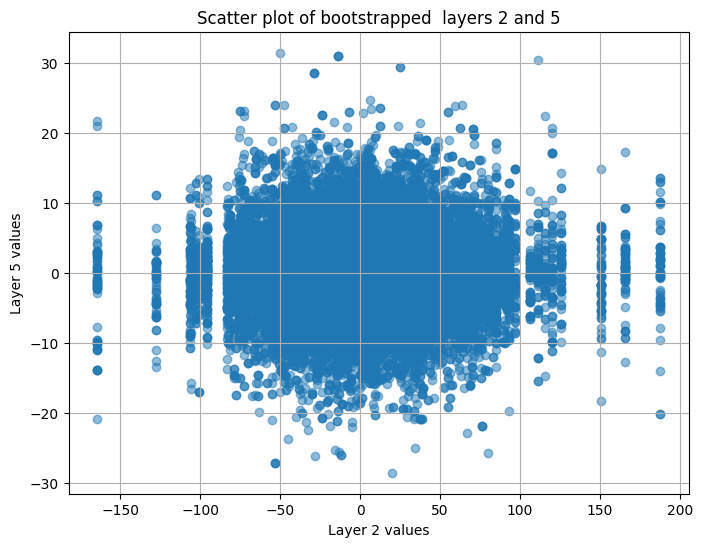

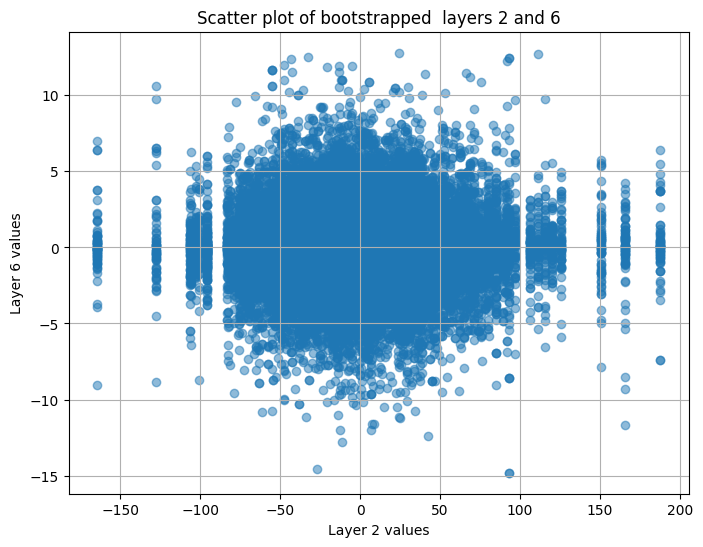

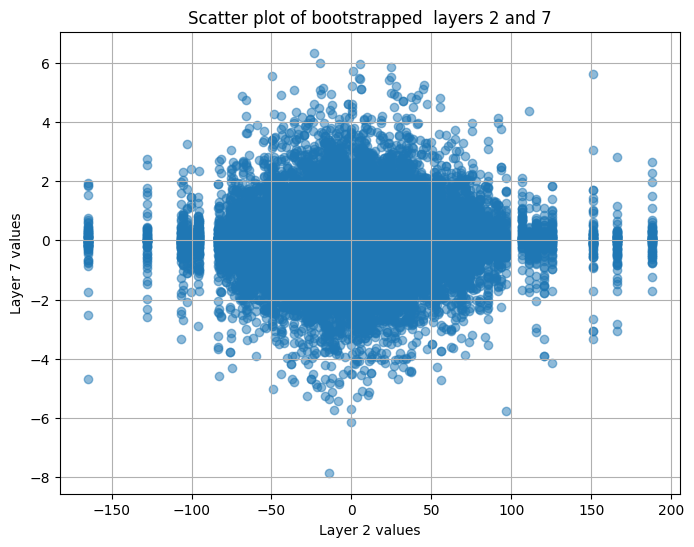

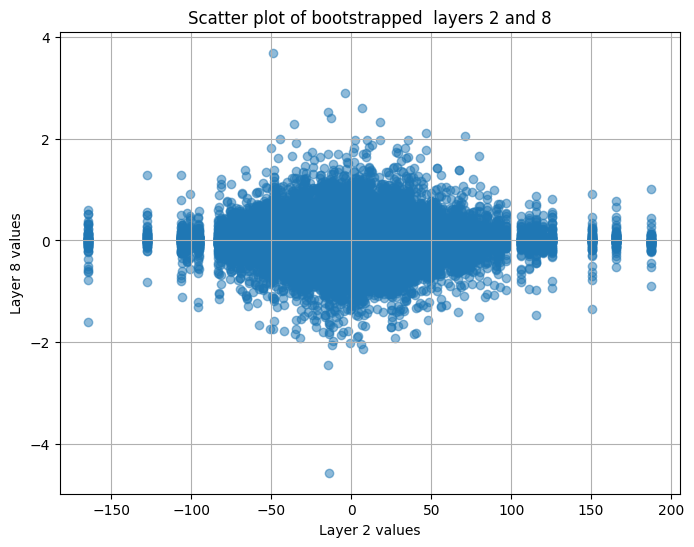

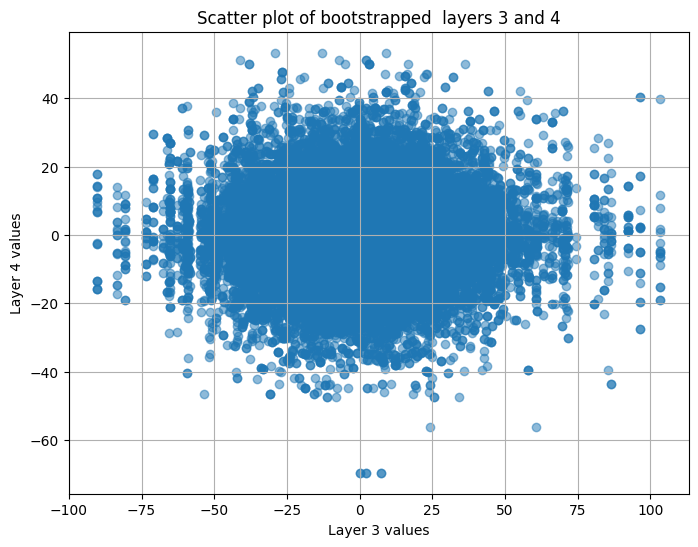

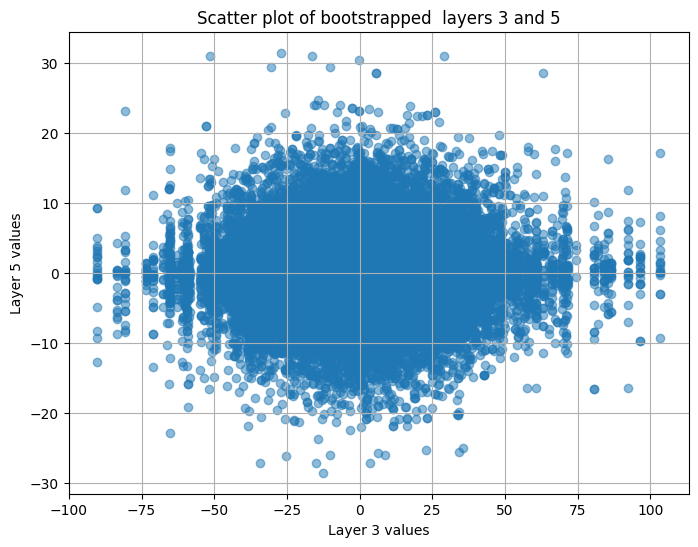

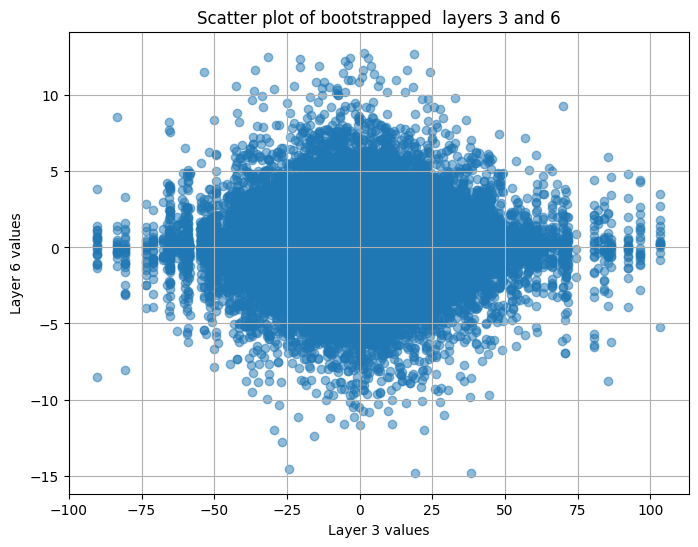

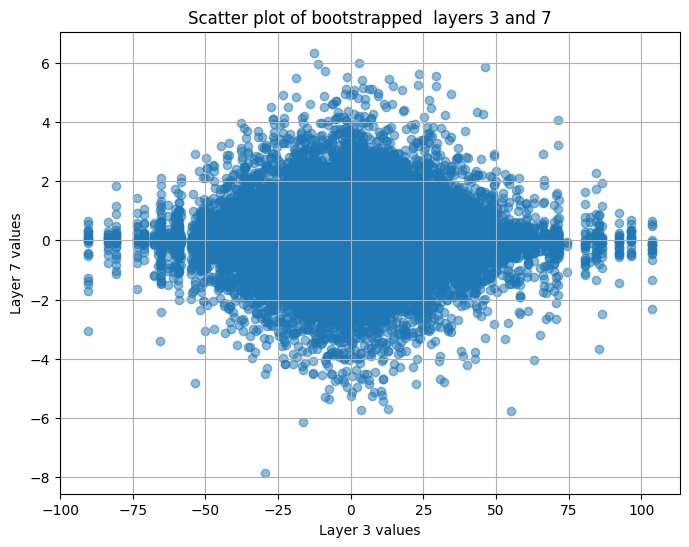

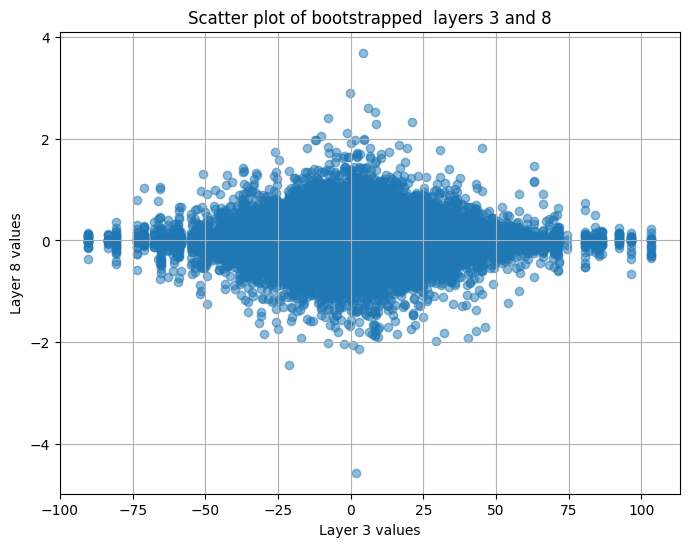

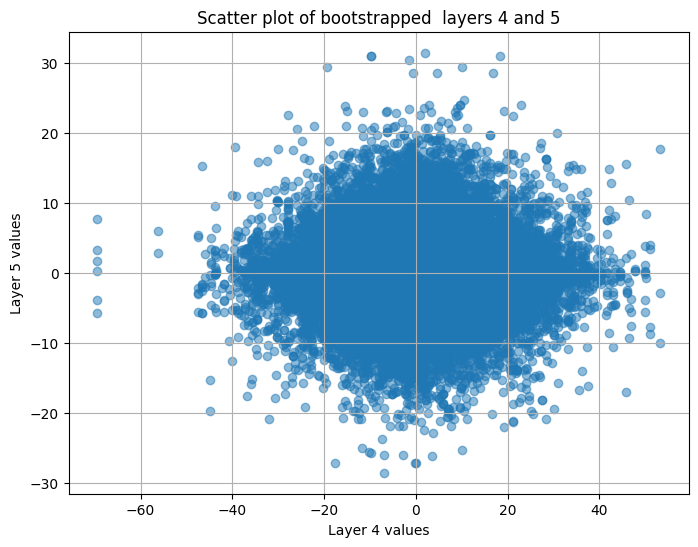

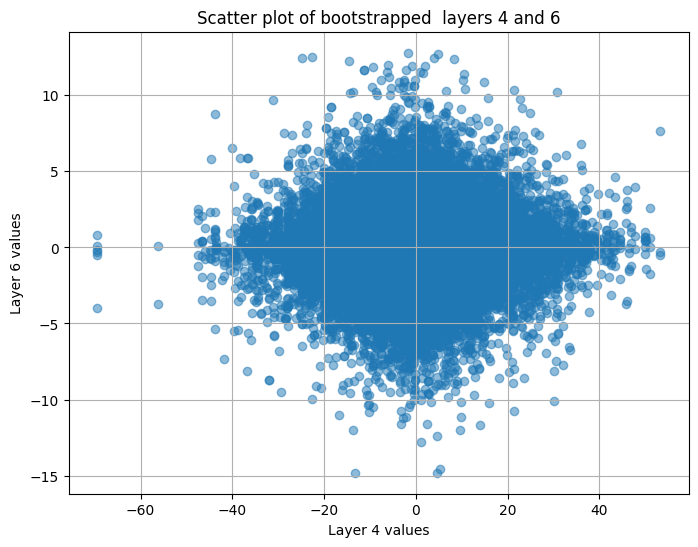

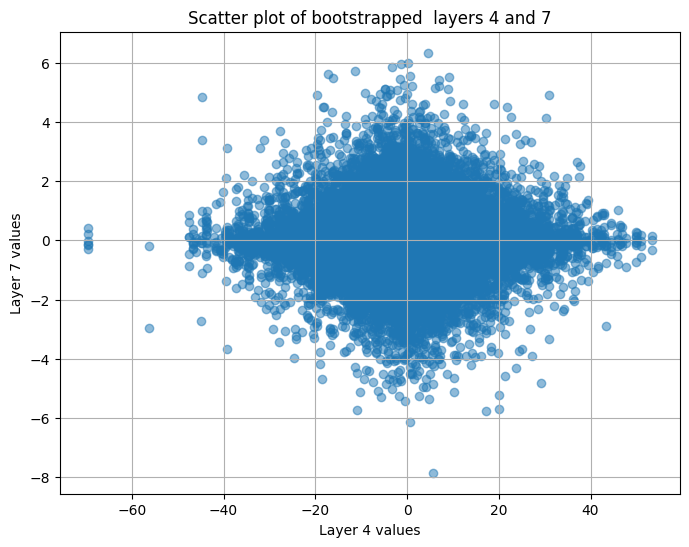

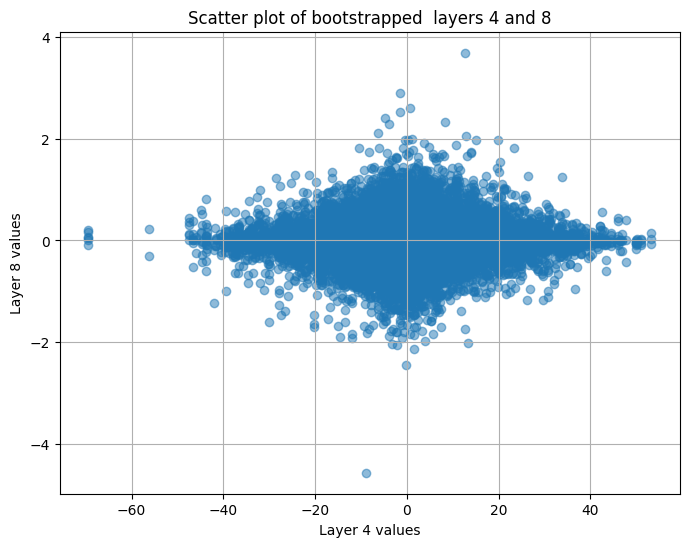

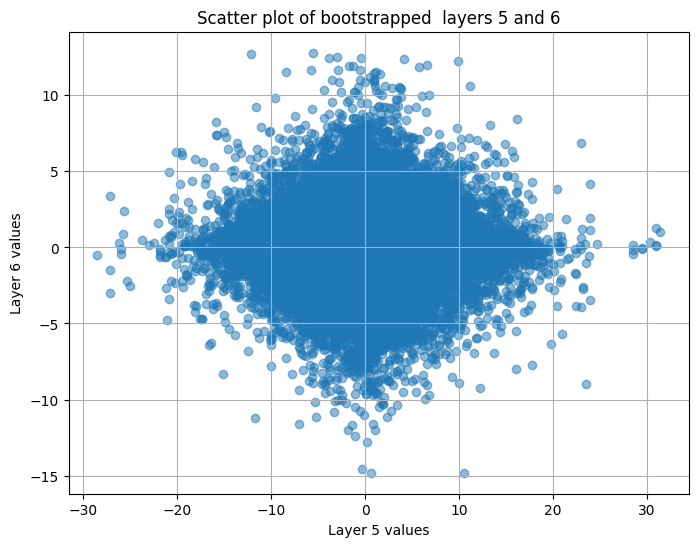

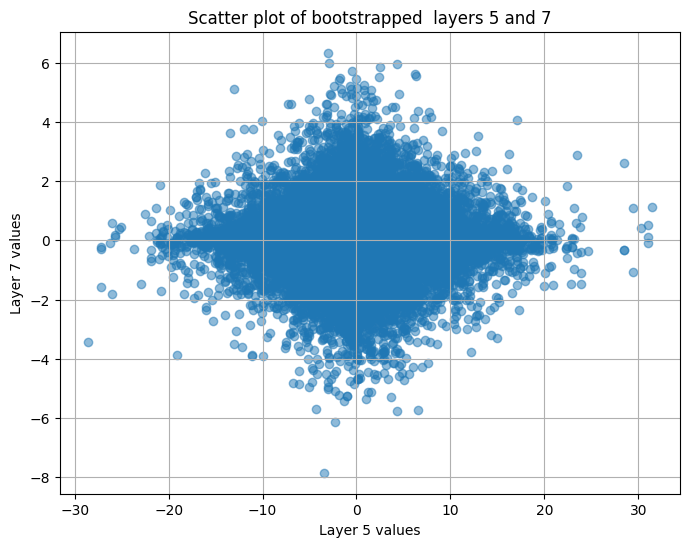

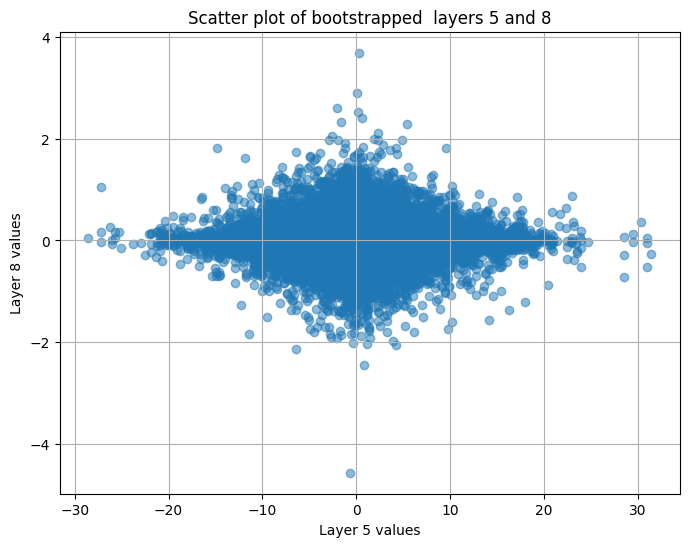

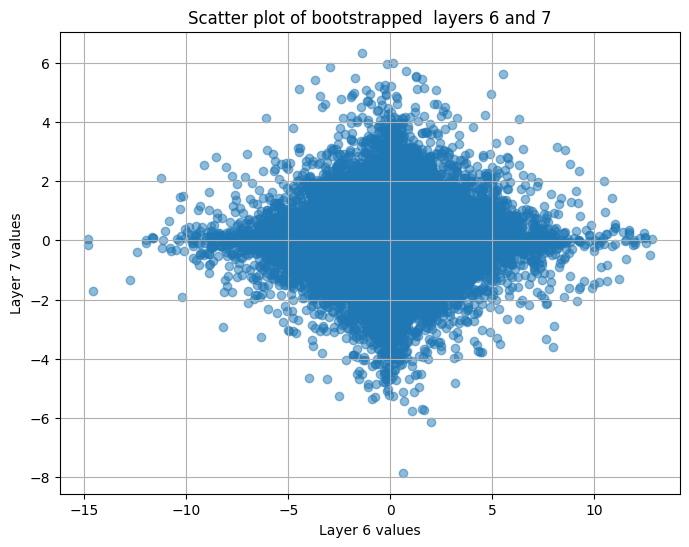

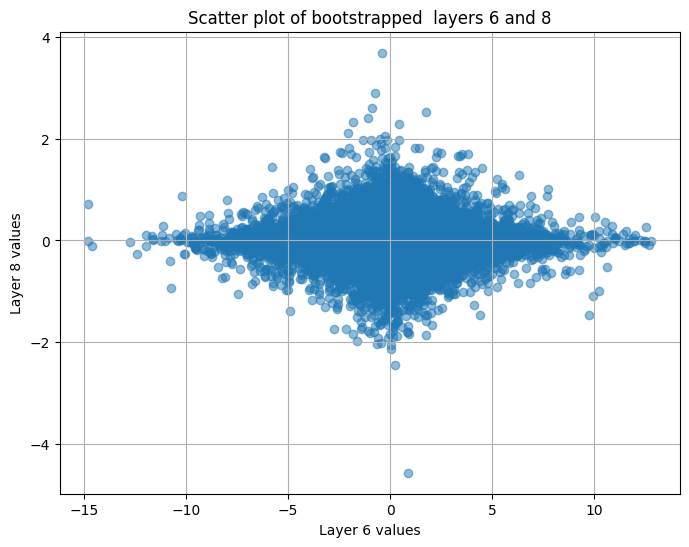

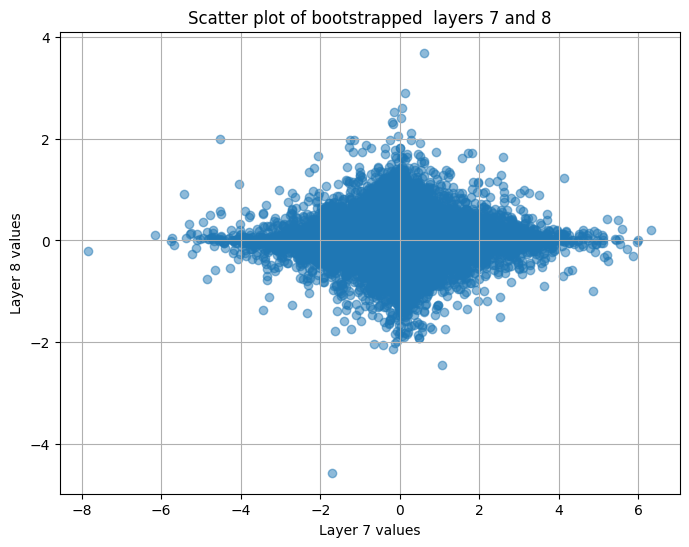

In [40]:
for x1 in range(2, max(channel_wv["layer"])+ 1):
    for x2 in range(x1+1, max(channel_wv["layer"])+1):
        samples_train = np.array([full_arr_train[x1-2], full_arr_train[x2-2]]).T

        plt.figure(figsize=(8, 6))
        plt.scatter(samples_train[:, 0], samples_train[:, 1], alpha=0.5)
        plt.xlabel(f'Layer {x1} values')
        plt.ylabel(f'Layer {x2} values')
        plt.title(f'Scatter plot of bootstrapped  layers {x1} and {x2}')
        plt.grid(True)
        plt.show()
